### TODO
- states and params share variable names: invalid coord names

In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
import os
os.environ["THEANO_FLAGS"] = "floatX=float64"

In [3]:
import logging
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import pymc3 as pm
import theano
import theano.tensor as tt

# this notebook show DEBUG log messages
# logging.getLogger('pymc3').setLevel(logging.DEBUG)

import arviz
import IPython.display

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


# pymc3.ode: Shapes and benchmarking

### Demo Scenario: Simple enzymatic reaction
The model has two ODEs with 3 parameters in total.

In our generated data, we'll observe `S` and `P` at different times to demonstrate how to slice in such cases.

672 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


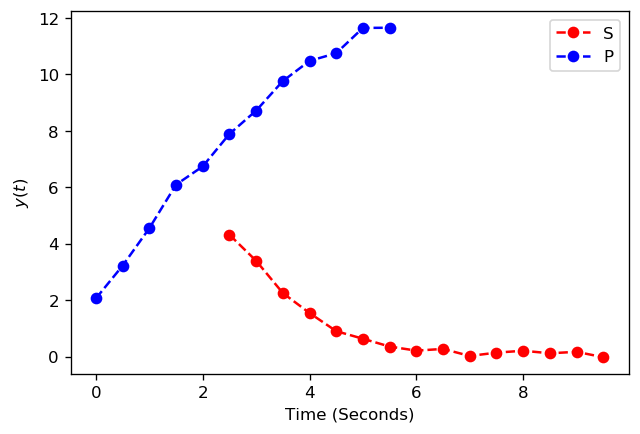

In [4]:
# For reproducibility
np.random.seed(23489)
n_extra = 1

class Chem:
    @staticmethod
    def reaction(y, t, p):
        S, P = y[0], y[1]
        vmax, K_S = p[0], p[1]
        dPdt = vmax * S / (K_S + S)
        dSdt = -dPdt
        return [dSdt, dPdt] + [
            dPdt * p[2:][i] for i in range(n_extra)
        ]

# Times for observation
times = np.arange(0,10,0.5)
red = np.arange(5, len(times))
blue = np.arange(12)
x_obs_1 = times[red]
x_obs_2 = times[blue]

y0_true = (10, 2)
y0_true = y0_true + tuple(np.ones(n_extra))
theta_true = vmax, K_S = (3, 2)
theta_true = theta_true + tuple(np.ones(n_extra))
sigma = 0.2

y_obs = odeint(Chem.reaction, t=times, y0=y0_true, args=(theta_true,))
%timeit odeint(Chem.reaction, t=times, y0=y0_true, args=(theta_true,))
y_obs_1 = np.random.normal(y_obs[red,0], sigma)
y_obs_2 = np.random.normal(y_obs[blue,1], sigma)

fig, ax = plt.subplots(dpi=120)
plt.plot(x_obs_1, y_obs_1, label='S', linestyle='dashed', marker='o', color='red')
plt.plot(x_obs_2, y_obs_2, label='P', linestyle='dashed', marker='o', color='blue')
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$')
plt.show()

In [5]:
# To demonstrate that test-value computation works, but also for debugging
theano.config.compute_test_value = 'raise'
theano.config.exception_verbosity = 'high'
theano.config.traceback.limit = 5

In [6]:
def reaction_sympy(t, y, p):
    dPdt = p.vmax * y.S / (p.K_S + y.S)
    return {
        'S': -dPdt,
        'P': dPdt,
        'extra': p.extra_p * dPdt,
    }

In [7]:
import sunode.symode.paramset
import sunode.symode.problem
import sunode.wrappers.as_theano


def get_model_sunode():
    with pm.Model() as pmodel:
        sigma = pm.HalfCauchy('sigma', 1)
        vmax = pm.Lognormal('vmax', 0, 1)
        K_S = pm.Lognormal('K_S', 0, 1)
        s0 = pm.Normal('red_0', mu=10, sd=2)
        extra = pm.Normal('extra', shape=n_extra)

        y_hat, _, _ = sunode.wrappers.as_theano.solve_ivp(
            y0={
                'S': (s0, ()),  # TODO Infer shape from model?
                'P': np.array(y0_true[1], dtype='d'),
                'extra': (np.ones(n_extra), n_extra),
            },
            params={
                'K_S': (K_S, ()),
                'vmax': (vmax, ()),
                'tmp': np.zeros(1),  # TODO theano wants at least one fixed param
                'extra_p': (extra, (n_extra,))
            },
            rhs=reaction_sympy,
            tvals=times,
            t0=times[0],
        )

        red_hat = y_hat['S'][red]
        blue_hat = y_hat['P'][blue]
        
        pm.Deterministic('solution_S', y_hat['S'])
        pm.Deterministic('solution_P', y_hat['P'])

        Y_red = pm.Normal('Y_red', mu=red_hat, sd=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sd=sigma, observed=y_obs_2)

    return pmodel


def get_model_sunode_reparam():
    with pm.Model() as pmodel:
        sigma = pm.HalfCauchy('sigma', 1)
        K_S = pm.Lognormal('K_S', 0, 1)

        # Place a prior over the reaction rate at concentration 5
        # instead of vmax.
        # mu and sd are chosen so that the prior is very similar
        # to the original model.
        c = 5
        log_v = pm.Normal('log_v', mu=-0.22, sd=1)

        vmax = np.exp(log_v) * (c + K_S) / c
        pm.Deterministic('vmax', vmax)

        s0 = pm.Normal('red_0', mu=10, sd=2)
        
        extra = pm.Normal('extra', shape=n_extra)

        y_hat, problem, _ = sunode.wrappers.as_theano.solve_ivp(
            y0={
                'S': (s0, ()),  # TODO Infer shape from model?
                'P': np.array(y0_true[1], dtype='d'),
                'extra': (np.ones(n_extra), n_extra),
            },
            params={
                'K_S': (K_S, ()),
                'vmax': (vmax, ()),
                'tmp': np.zeros(1),  # TODO theano wants at least one fixed param
                'extra_p': (extra, (n_extra,))
            },
            rhs=reaction_sympy,
            tvals=times,
            t0=times[0],
        )

        red_hat = y_hat['S'][red]
        blue_hat = y_hat['P'][blue]
        
        pm.Deterministic('solution_S', y_hat['S'])
        pm.Deterministic('solution_P', y_hat['P'])
        
        Y_red = pm.Normal('Y_red', mu=red_hat, sd=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sd=sigma, observed=y_obs_2)

    return pmodel

In [8]:
def get_model():
    with pm.Model() as pmodel:    
        sigma = pm.HalfCauchy('sigma', 1)
        vmax = pm.Lognormal('vmax', 0, 1)
        K_S = pm.Lognormal('K_S', 0, 1)
        s0 = pm.Normal('red_0', mu=10, sd=2)
        
        extra = pm.Normal('extra', shape=n_extra)

        y_hat = pm.ode.DifferentialEquation(
            func=Chem.reaction,
            times=times,
            n_states=len(y0_true), n_theta=len(theta_true)
        )(
            y0=[s0, y0_true[1]] + list(np.ones(n_extra)),
            theta=[vmax, K_S] + [extra[i] for i in range(n_extra)],
            return_sens=False
        )

        red_hat = y_hat.T[0][red]
        blue_hat = y_hat.T[1][blue]

        Y_red = pm.Normal('Y_red', mu=red_hat, sd=sigma, observed=y_obs_1)
        Y_blue = pm.Normal('Y_blue', mu=blue_hat, sd=sigma, observed=y_obs_2)

    return pmodel

def make_benchmark(pmodel):    
    # select input variables & test values
    t_inputs = pmodel.cont_vars
    # apply transformations as required
    test_inputs = (np.log(0.2), np.log(0.5), np.log(1.9), 10, np.ones(n_extra))
    
    # create a test function for evaluating the logp value
    print('Compiling f_logpt')
    f_logpt = theano.function(
        inputs=t_inputs,
        outputs=[pmodel.logpt],
        # with float32, allow downcast because the forward integration is always float64
        allow_input_downcast=(theano.config.floatX == 'float32')
    )
    print(f'Test logpt:')
    print(f_logpt(*test_inputs))
    
    # and another test function for evaluating the gradient
    print('Compiling f_logpt')
    f_grad = theano.function(
        inputs=t_inputs,
        outputs=tt.grad(pmodel.logpt, t_inputs),
        # with float32, allow downcast because the forward integration is always float64
        allow_input_downcast=(theano.config.floatX == 'float32')
    )
    print(f'Test gradient:')
    print(f_grad(*test_inputs))
    
    # make a benchmarking function that uses random inputs
    # - to avoid cheating by caching
    # - to get a more realistic distribution over simulation times
    vals = [
        np.log(np.random.uniform(0.1, 0.2)),
        np.log(np.random.uniform(0.4, 0.6)),
        np.log(np.random.uniform(1.9, 2.1)),
        np.random.uniform(9, 11),
        np.random.randn(n_extra),
    ]

    def bm_val():
        f_logpt(*vals)
    
    def bm_grad():
        f_grad(*vals)

    return pmodel, bm_val, bm_grad

In [9]:
model, benchmark, benchmark_grad = make_benchmark(get_model())
model_sunode, benchmark_sunode, benchmark_grad_sunode = make_benchmark(get_model_sunode())
model_sunode_reparam = get_model_sunode_reparam()

print('\nPerformance:')
%timeit benchmark()
%timeit benchmark_sunode()
%timeit benchmark_grad()
%timeit benchmark_grad_sunode()

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn("Your cuDNN version is more recent than "


Compiling f_logpt
Test logpt:
[array(-12365.93303267)]
Compiling f_logpt
Test gradient:
[array(24728.24539402), array(7984.60038498), array(-1435.26565838), array(-2299.84976284), array([-1.])]
Compiling f_logpt
Test logpt:
[array(-12365.93304032)]
Compiling f_logpt
Test gradient:
[array(24728.24540933), array(7984.60044266), array(-1435.26568584), array(-2299.84977474), array([-1.])]

Performance:
8.21 ms ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
234 µs ± 501 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
8.2 ms ± 25.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.35 ms ± 2.78 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
with model_sunode:
    trace = pm.sample(draws=1000, cores=8, chains=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [extra, red_0, K_S, vmax, sigma]


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.


In [11]:
with model_sunode_reparam:
    trace_trafo = pm.sample(draws=1000, cores=8, chains=8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [extra, red_0, log_v, K_S, sigma]


The acceptance probability does not match the target. It is 0.882638315374893, but should be close to 0.8. Try to increase the number of tuning steps.


## Compare the original model with the reparametrization

In [12]:
import arviz
import xarray as xr
import seaborn as sns

In [13]:
tr = arviz.from_pymc3(trace)
tr_traf = arviz.from_pymc3(trace_trafo)

traces = xr.concat([tr.posterior, tr_traf.posterior], dim='model')

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


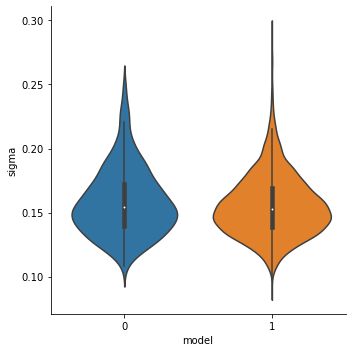

In [14]:
sns.factorplot('model', 'sigma', data=traces.sigma.to_dataframe().reset_index(), kind='violin')

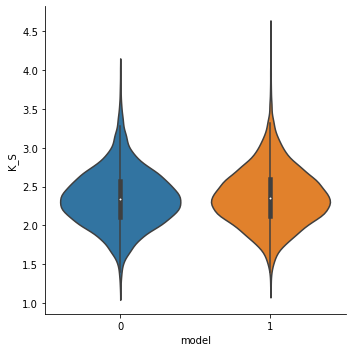

In [26]:
sns.factorplot('model', 'K_S', data=traces.K_S.to_dataframe().reset_index(), kind='violin')

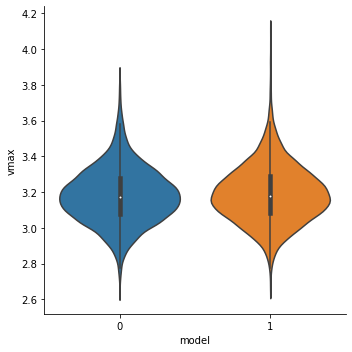

In [27]:
sns.factorplot('model', 'vmax', data=traces.vmax.to_dataframe().reset_index(), kind='violin')

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotl

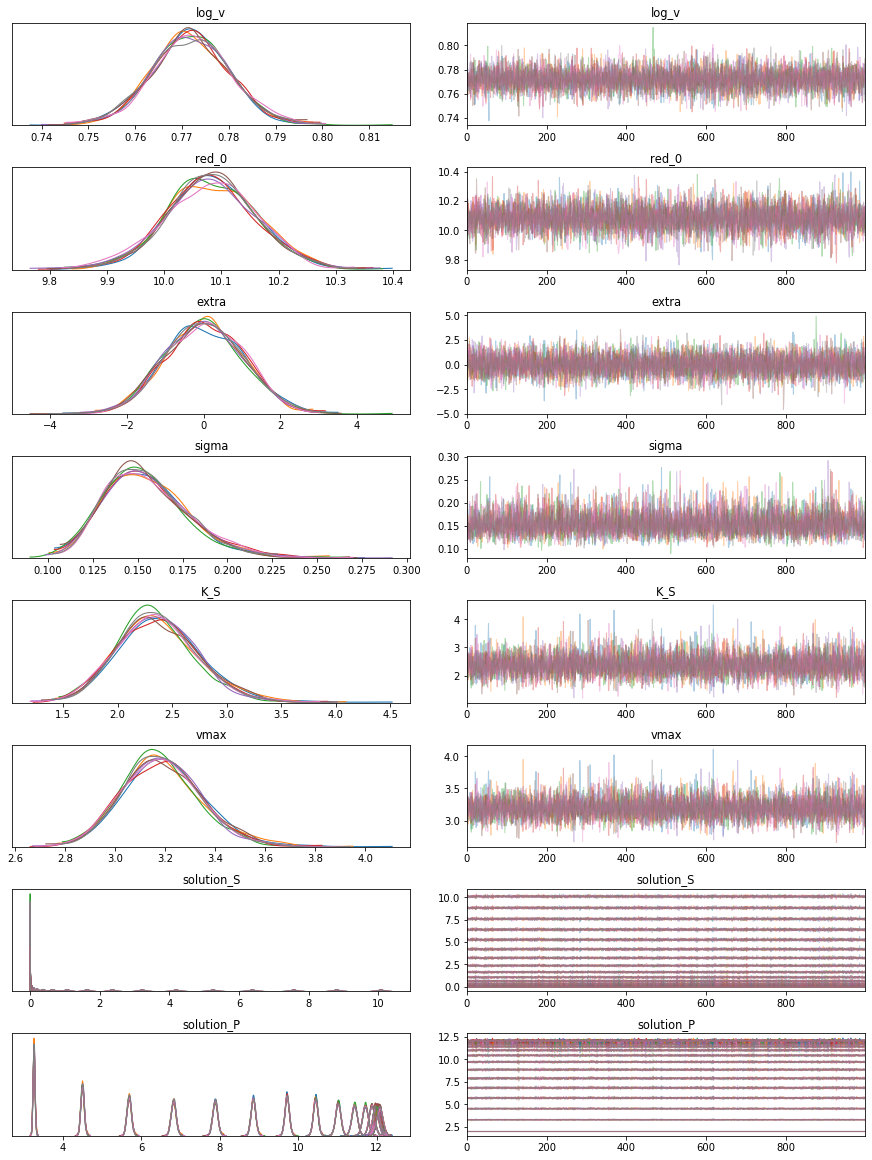

In [28]:
pm.traceplot(trace_trafo);

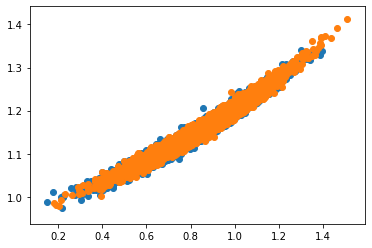

In [29]:
a = np.log(trace['K_S'])
b = np.log(trace['vmax'])
plt.scatter(a, b)

a = np.log(trace_trafo['K_S'])
b = np.log(trace_trafo['vmax'])
plt.scatter(a, b)

In [30]:
plt.plot(trace['y_hat'][0])
plt.plot(trace['y_hat'][-1])
plt.plot(trace['y_hat'][-100])

KeyError: 'Unknown variable y_hat'

### Why the reparametrization?

This doesn't look so great:

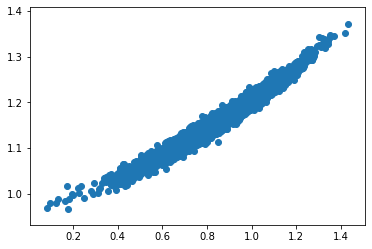

In [22]:
a = np.log(trace['K_S'])
b = np.log(trace['vmax'])
plt.scatter(a, b)

If we use the reaction rate for c == 5 instead of vmax, this looks much better:

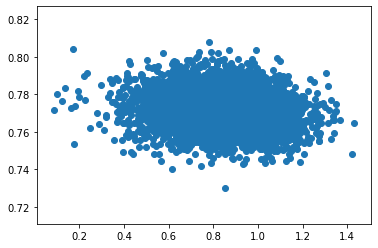

In [24]:
c = 5
a = np.log(trace['K_S'])
b = np.log(trace['vmax'] * c / (c + trace['K_S']))
plt.scatter(a, b)

We try to find a distribution for v(5) that results to a similar prior on vmax as the original:

In [33]:
with model_sunode:
    prior = pm.sample_prior_predictive()
with model_sunode_reparam:
    prior_trafo = pm.sample_prior_predictive()

In [34]:
c = 5
prior_v = prior['vmax'] * c / (c + prior['K_S'])
prior_trafo_v = prior['vmax'] * c / (c + prior['K_S'])

In [35]:
np.log(prior_v).mean(), np.log(prior_v).std()

(-0.16983597477530996, 1.0448665394359002)

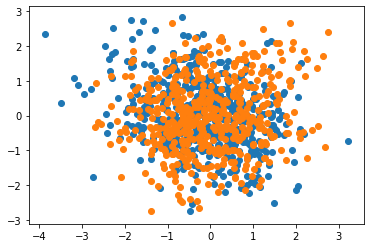

In [36]:
plt.scatter(np.log(prior_v), np.log(prior['K_S']))
plt.scatter(np.log(prior_trafo['vmax']), np.log(prior_trafo['K_S']))

### Investigate the trafo a bit :-)

In [20]:
import sympy as sym

In [39]:
log_vmax, log_K = sym.symbols('log_v_max, log_K', real=True)
#vmax, K = sym.symbols('v_max, K', positive=True)
c = sym.Symbol('c', positive=True)

vmax = sym.exp(log_vmax)
K = sym.exp(log_K)

v = vmax * c / (c + K)
log_v = sym.log(v)
dv = v.diff(c)
log_dv = sym.log(dv)

In [40]:
m = sym.Matrix([log_v, log_K])
m.simplify()
m

Matrix([
[log_v_max + log(c) - log(c + exp(log_K))],
[                                   log_K]])

In [41]:
(sym.Matrix([log_v, log_dv]).jacobian(sym.Matrix([log_vmax, log_K])).det()).simplify()

c/(c + exp(log_K))

In [ ]:
c = sym.symbols('c', positive=True)
log_sd, x = sym.symbols('log_sd, x', real=True)

sd = sym.exp(log_sd)


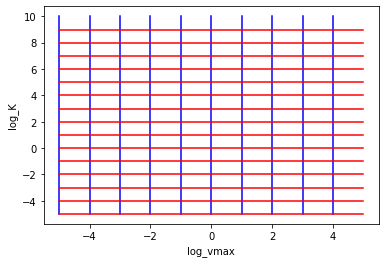

In [42]:
func = sym.lambdify([log_vmax, log_K, c], [log_vmax, log_K])

lv, ldv = func(np.arange(-5, 5)[None, :], np.linspace(-5, 10)[:, None], 5)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='blue');

lv, ldv = func(np.linspace(-5, 5)[:, None], np.arange(-5, 10)[None, :], 5)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='red');

plt.xlabel('log_vmax')
plt.ylabel('log_K');

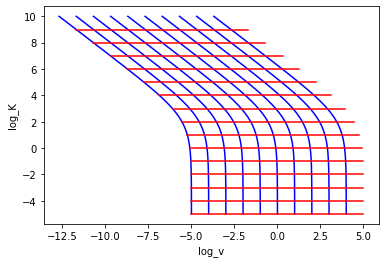

In [43]:
func = sym.lambdify([log_vmax, log_K, c], [log_v, log_K])
lv, ldv = func(np.arange(-5, 5)[None, :], np.linspace(-5, 10)[:, None], 10)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='blue');

lv, ldv = func(np.linspace(-5, 5)[:, None], np.arange(-5, 10)[None, :], 10)
plt.plot(lv + 0 * ldv, ldv + 0 * lv, color='red');

plt.xlabel('log_v')
plt.ylabel('log_K');

In [44]:
c = np.linspace(0, 15)[:, None, None]
K_S = np.array([3, 4, 5])[None, :, None]
vmax = np.array([0.1, 0.2, 0.3])[None, None, :]
vals = (vmax * c) / (c + K_S)
#plt.plot((vmax * c) / (c + K_S))

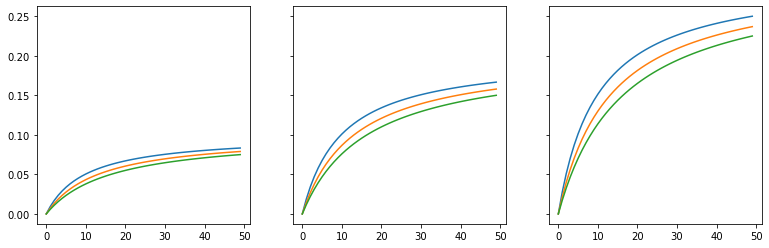

In [45]:
n_subplots = len(vmax.ravel())
fig, axes = plt.subplots(1, n_subplots, figsize=(13, 4), sharex=True, sharey=True)
#plt.plot(vals[:, 0, 1])
for i in range(n_subplots):
    axes[i].plot(vals[:, :, i])

### Inspecting the computation graphs
If you zoom in to the large `DifferentialEquation` ellipse in the top, you can follow the blue arrows downwards to see that the gradient is directly passed from the original DifferentialEquation Op node.

In [46]:
theano.printing.pydotprint(tt.grad(model_sunode.logpt, model_sunode.vmax), 'ODE_API_shapes_and_benchmarking.png')
IPython.display.Image('ODE_API_shapes_and_benchmarking.png')

The output file is available at ODE_API_shapes_and_benchmarking.png


With the cell below, you can visualize the computation graph interactively. (The HTML file is saved next to this notebook.)

If you need to install `graphviz/pydot`, you can use these commands:
```
conda install -c conda-forge python-graphviz
pip install pydot
```

In [9]:
from theano import d3viz
d3viz.d3viz(model.logpt, 'ODE_API_shapes_and_benchmarking.html')